In [27]:
import pandas as pd
import numpy as np
from plotnine import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
%%bash
rm -f arith.txt
find Benchs -name 'arith.txt' >> arith.txt

In [3]:
files = []
with open('arith.txt') as f:
    for line in f:
        files.append(line.strip())

In [4]:
insts = ['Add', 'Sub', 'Xor', 'Shl', 'LShr', 'AShr', 'Mul', 'UDiv', 'SDiv', 'And', 'Or']
header = insts + [ x + '_total' for x in insts]

In [100]:
df = pd.DataFrame(columns=['Benchmark', 'Group'] + header)
for f in files:
    df2 = pd.read_csv(f, header=None).transpose()
    df2.columns = df2.iloc[0]
    df2 = df2[1:]
    d = dict()
    for h in insts:
        try:
            d[h] = float(df2.iloc[0][h])/float(df2.iloc[1][h])
        except:
            d[h] = 0.0
        d[h + '_total'] = df2.iloc[1][h]
    d['Benchmark'] = f.split('/')[1] if len(f.split('/')) == 3 else f.split('/')[2]
    d['Group'] = f.split('/')[1]
    df = df.append(d, ignore_index=True)

df = df.round(3)


for h in insts:
    df[h + '_total'] = df[h + '_total'].astype(np.int64)

In [101]:
df.head()

,Benchmark,Group,Add,Sub,Xor,Shl,LShr,AShr,Mul,UDiv,...,Sub_total,Xor_total,Shl_total,LShr_total,AShr_total,Mul_total,UDiv_total,SDiv_total,And_total,Or_total
0,mandel-2,Misc,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0,0,313683990,0
1,dt,Misc,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,2048,0,0,0,0,0,0,0,0,67108864
2,flops-5,Misc,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0,0,0,0
3,flops-2,Misc,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0,0,0,0
4,oourafft,Misc,0.010,0.024,0.000,0.027,1.000,0.000,0.000,0.000,...,36900527,0,173103054,300004,1200015,1806162,0,0,1800021,607657355


In [51]:
# df.to_clipboard(float_format='%.3f')

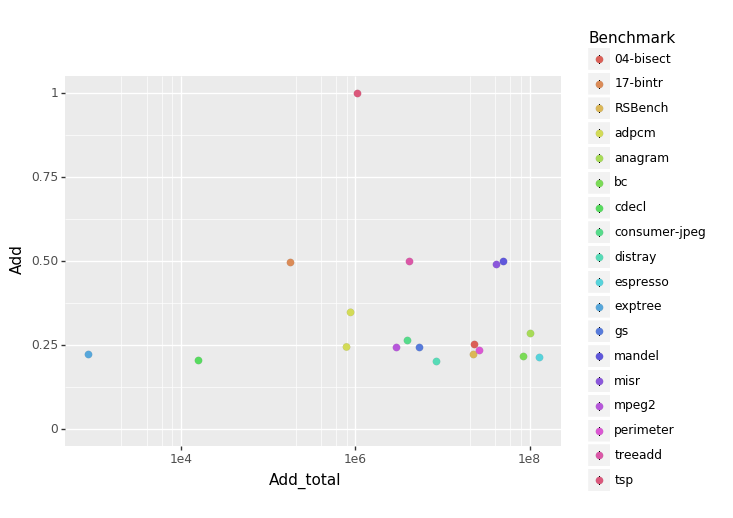

<ggplot: (282715575)>

In [135]:
(ggplot(df[(df.Add > 0.2) & (df.Add_total > 100)])
 + scale_x_log10()
 + geom_point(aes(x='Add_total', y='Add', fill='Benchmark'), stroke=0.02, size=3)
 + ylim((0, 1.0))
)

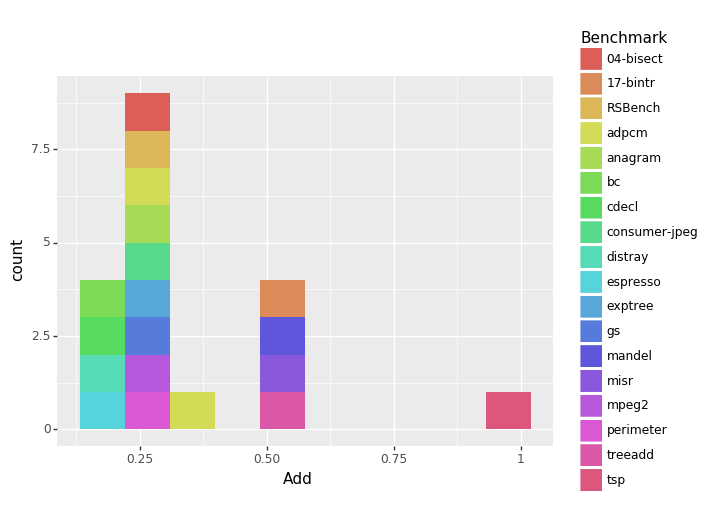

<ggplot: (-9223372036573423037)>

In [119]:
(ggplot(df[(df.Add > 0.2) & (df.Add_total > 100)], aes(x='Add'))
 + geom_histogram(aes(fill='Benchmark'), bins=10)
)

In [129]:
df.query('Add > 0.4')[['Group', 'Benchmark', 'Add', 'Add_total']]

,Group,Benchmark,Add,Add_total
9,Misc,mandel,0.500,50005000
29,Prolangs-C,fixoutput,1.000,1
31,Prolangs-C,unix-smail,0.488,43
160,McGill,misr,0.493,40800011
176,McCat,17-bintr,0.499,180200
200,Olden,tsp,1.000,1048577
207,Olden,treeadd,0.500,4194300


- **Prolangs-C/fixoutput**: Total is too small
- **Prolangs-C/unix-small**: Total is too small
- **Olden/tsp**: Good candidate, only 3 add instructions:
  - static_id[0] = 1, 1
  - static_id[1] = 699049, 1  <- Is the identity most of the time  (Tree initialization)
    - ex: build_tree(n/2,dir,**lo+num_proc/2**,num_proc/2,min_x,med,min_y,max_y);
  - static_id[2] = 349525, 0  <- Is the identity every single time (Tree initialization)
- **Misc/mandel**: Has one good candidate
  - static_id[0] = 25000000, 0 <- this one here (Initialization)
  - static_id[1] = 5000, 24995000
  - static_id[2] = 1, 4999
- **McGill/misr**: Has quite a few good candidates
  - ...
  - static_id[9] = 9000000, 0
  - static_id[10] = 4499209, 4500791
  - static_id[11] = 4503839, 4496161
  - static_id[12] = 1000000, 8000000
  - ...
  - static_id[14] = 500464, 499536
  - static_id[15] = 500729, 499271
  - static_id[16] = 100000, 900000
  - ...
- **McCat/17-bintr**: 2 out of 4 candidates
  - static_id[0] = 44902, 45098  <- this one
  - static_id[1] = 45100, 44900  <- and this one
  - static_id[2] = 1, 99
  - static_id[3] = 1, 99
- **Olden/treeadd**: 
  - static_id[0] = 524288, 524287 *****
  - static_id[1] = 524288, 524287 *****
  - static_id[2] = 0, 1048575
  - static_id[3] = 1048574, 1     *****